# Ecosystem Models

In [1]:
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using AlgebraicDynamics.UWDDynam

using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Programs

using LabelledArrays
using OrdinaryDiffEq
using Plots, Plots.PlotMeasures

There will be 16 parameters in to the total ecosystem. With four distinct types:
- parameters $\alpha$ represent the rate at which a species population grows
- parameters $\beta$ represent the rate at which a population of prey declines in a predation interaction
- parameters $\gamma$ represent the rate at which a population of predators grows in a predation interaction
- parameters $\delta$ represent the rate at with a species population declines

In [2]:
params = LVector(αr=0.3, βrf=0.015, γrf=0.015, δf=0.7,
                 βrh=0.01, γrh=0.01, δh=0.5,
                 γfishh=0.001, βfishh=0.003,
                 αfish=0.35, βfishF=0.015, γfishF=0.015,
                 δF=0.7, βFs=0.017, γFs=0.017, δs=0.35)

16-element LabelledArrays.LArray{Float64, 1, Vector{Float64}, (:αr, :βrf, :γrf, :δf, :βrh, :γrh, :δh, :γfishh, :βfishh, :αfish, :βfishF, :γfishF, :δF, :βFs, :γFs, :δs)}:
     :αr => 0.3
    :βrf => 0.015
    :γrf => 0.015
     :δf => 0.7
    :βrh => 0.01
    :γrh => 0.01
         ⋮
 :γfishF => 0.015
     :δF => 0.7
    :βFs => 0.017
    :γFs => 0.017
     :δs => 0.35

## Land Ecosystem

### Rabbits and foxes

A standard Lotka Volterra predator-prey model is the composition of three primitive resource sharers:

1. a model of rabbit growth: this resource sharer has dynamics $\dot r(t) = \alpha r(t)$ and one port which exposes the rabbit population.
2. a model of rabbit/fox predation: this resource sharer has dynamics $$\dot r(t) = -\beta r(t) f(t), \dot f(t) = \gamma r(t)f(t)$$ and two ports which expose the rabbit and fox populations respectively.
3. a model of fox population decline: this resource sharer has dynamics $\dot f(t) = -\delta f(t)$ and one port which exposes the fox population.

However, there are not two independent rabbit populations -- one that grows and one that gets eaten by foxes. Likewise, there are not two independent fox populations -- one that declines and one that feasts on rabbits. To capture these interactions between the trio of resource sharers, we compose them by identifying the exposed rabbit populations and identifying the exposed fox populations.
The syntax for this undirected composition is defined by an undirected wiring diagram.

In [3]:
# Define the primitive systems
dotr(u,p,t) = p.αr*u
dotrf(u,p,t) = [-p.βrf*u[1]*u[2], p.γrf*u[1]*u[2]]
dotf(u,p,t) = -p.δf*u

rabbit_growth = ContinuousResourceSharer{Float64}(1, dotr)
rabbitfox_predation = ContinuousResourceSharer{Float64}(2, dotrf)
fox_decline = ContinuousResourceSharer{Float64}(1, dotf)

# Define the composition pattern
rabbitfox_pattern = @relation (rabbits, foxes) begin
    rabbit_growth(rabbits)
    rabbitfox_predation(rabbits,foxes)
    fox_decline(foxes)
end

# Compose
submodels = Dict(
    :rabbit_growth => rabbit_growth,
    :rabbitfox_predation => rabbitfox_predation,
    :fox_decline => fox_decline
)
rabbitfox_system = oapply(rabbitfox_pattern, submodels)

Previously, when we derived the Lotka-Volterra model via [undirected composition](https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/examples/Lotka-Volterra/#Undirected-composition), we by-hand defined the undirected wiring diagram that implements the composition pattern. In contrast, here we implement the same composition pattern as before but this time using the [`@relation` macro](https://algebraicjulia.github.io/Catlab.jl/stable/apis/programs/#Catlab.Programs.RelationalPrograms.@relation-Tuple). This strategy simplifies the definition and explicitly names the boxes and variables. We  visualize the composition pattern below.

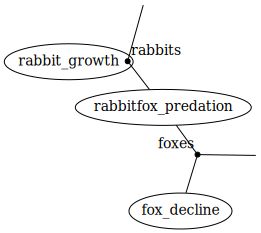

In [4]:
to_graphviz(rabbitfox_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))

We can now construct an `ODEProblem` from the resource sharer `rabbitfox_system` and plot the solution.

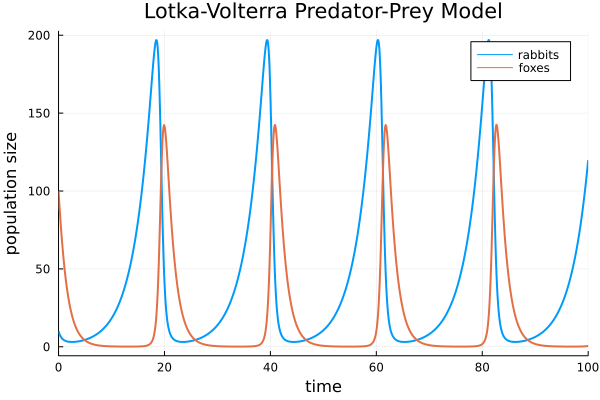

In [5]:
u0 = [10.0, 100.0]
tspan = (0.0, 100.0)

prob = ODEProblem(rabbitfox_system, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, rabbitfox_system,
    lw=2,
    title = "Lotka-Volterra Predator-Prey Model",
    xlabel = "time", ylabel = "population size")

### Rabbits, foxes, and hawks
Suppose we now have a three species ecosystem containing rabbits, foxes, and hawks. Foxes and hawks both prey upon rabbits but do not interact with each other. This ecosystem consists of five primitive systems which share variables.
1. rabbit growth:  $\dot r(t) = \alpha r(t)$
2. rabbit/fox predation:  $\dot r(t) = -\beta r(t) f(t), \dot f(t) = \delta r(t)f(t)$
3. fox decline:  $\dot f(t) = -\gamma f(t)$
4. rabbit/hawk predation: $\dot r(t) = -\beta' r(t)h(t), \dot h(t) = \delta' r(t)h(t)$
5. hawk decline:  $\dot h(t) = -\gamma' h(t)$

This means the desired composition pattern has five boxes and many ports and wires to keep track of. Instead of implementing this composition pattern by hand, we construct it as a pushout.

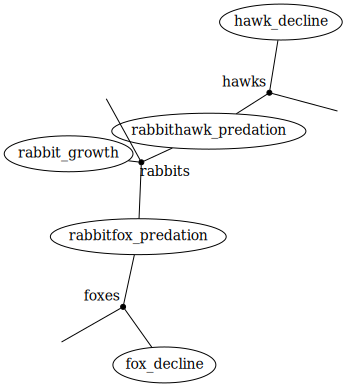

In [6]:
# Define the composition pattern for rabbit growth
rabbit_pattern = @relation (rabbits,) -> rabbit_growth(rabbits)

# Define the composition pattern for the rabbit/hawk Lotka Volterra model
rabbithawk_pattern = @relation (rabbits, hawks) begin
    rabbit_growth(rabbits)
    rabbithawk_predation(rabbits,hawks)
    hawk_decline(hawks)
end

# Define transformations between the composition patterns
rabbitfox_transform  = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbitfox_pattern)
rabbithawk_transform = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbithawk_pattern)

# Take the pushout to define the composition pattern for the rabbit, fox, hawk system
rabbitfoxhawk_pattern = ob(pushout(rabbitfox_transform, rabbithawk_transform))

# Visualize the compsition pattern
to_graphviz(rabbitfoxhawk_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".9"))

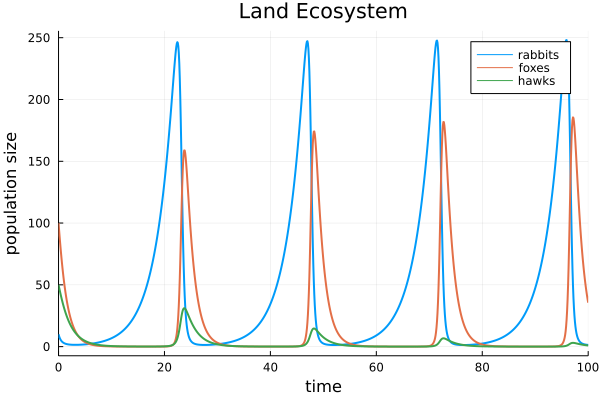

In [7]:
# Define the additional primitive systems
dotrh(u, p, t) = [-p.βrh*u[1]*u[2], p.γrh*u[1]*u[2]]
doth(u, p, t)  = -p.δh*u

rabbithawk_predation = ContinuousResourceSharer{Float64}(2, dotrh)
hawk_decline         = ContinuousResourceSharer{Float64}(1, doth)

# Compose
merge!(submodels, Dict(
    :rabbithawk_predation => rabbithawk_predation,
    :hawk_decline => hawk_decline
))

land_system = oapply(rabbitfoxhawk_pattern, submodels)

# Solve and plot
u0 = [10.0, 100.0, 50.0]
tspan = (0.0, 100.0)

prob = ODEProblem(land_system, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, land_system,
    lw=2,
    title = "Land Ecosystem",
    xlabel = "time", ylabel = "population size")

Unfortunately, the hawks are going extinct in this model. We'll have to give hawks something else to eat!

## Ocean Ecosystem

Consider a ocean ecosystem containing three species —- little fish, big fish, and sharks -— with two predation interactions —- sharks eat big fish and big fish eat little fish.

This ecosystem can be modeled as the composition of 3 machines:
1. Evolution of the little fish population:  this machine has one exogenous variable which represents a population of predators $h(t)$ that hunt little fish. This machine has one output which emits the little fish population. The dynamics of this machine is the driven ODE $$\dot f(t) = \alpha f(t) - \beta f(t)h(t)$$
2. Evolution of the big fish population:  this machine has two exogenous variables which represent a population of prey $e(t)$ that are eaten by big fish and a population of predators $h(t)$ which hunt big fish. This machine has one output which emits the big fish population. The dynamics of this machine is the drive ODE $$\dot F(t) = \gamma F(t)e(t) - \delta F(t) - \beta'F(t)h(t)$$
3. Evolution of the shark population:  this machine has one exogenous variable which represents a population of prey $e(t)$ that are eaten by sharks. This machine has one output which emits the shark population. The dynamics of this machine is the driven ODE $$\dot s(t) = \gamma's(t)e(t) - \delta's(t)$$

In [8]:
# Define the primitive systems
dotfish(f, x, p, t) = [p.αfish*f[1] - p.βfishF*x[1]*f[1]]
dotFISH(F, x, p, t) = [p.γfishF*x[1]*F[1] - p.δF*F[1] - p.βFs*x[2]*F[1]]
dotsharks(s, x, p, t) = [p.γFs*s[1]*x[1]-p.δs*s[1]]

fish   = ContinuousMachine{Float64}(1,1,1, dotfish,   (f,p,t)->f)
FISH   = ContinuousMachine{Float64}(2,1,1, dotFISH,   (F,p,t)->F)
sharks = ContinuousMachine{Float64}(1,1,1, dotsharks, (s,p,t)->s)

We compose these machines by (1) sending the output of the big fish machine as the input to both the little fish and shark machines and (2) sending the output of the little fish and shark machines as the inputs to the big fish machine.
The syntax for this directed composition is given by a directed wiring diagram.

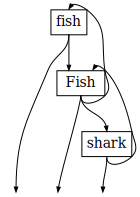

In [9]:
# Define the composition pattern
ocean_pattern = WiringDiagram([], [:fish, :Fish, :shark])
fish_box = add_box!(ocean_pattern, Box(:fish, [:pop], [:pop]))
Fish_box = add_box!(ocean_pattern, Box(:Fish, [:pop, :pop], [:pop]))
shark_box = add_box!(ocean_pattern, Box(:shark, [:pop], [:pop]))

output_box = output_id(ocean_pattern)
add_wires!(ocean_pattern, Pair[
    (fish_box, 1)  => (Fish_box, 1),
    (shark_box, 1) => (Fish_box, 2),
    (Fish_box, 1)  => (fish_box, 1),
    (Fish_box, 1)  => (shark_box, 1),
    (fish_box, 1)  => (output_box, 1),
    (Fish_box, 1)  => (output_box, 2),
    (shark_box, 1) => (output_box, 3)
])

# Visualize the composition pattern
to_graphviz(ocean_pattern, orientation=TopToBottom)

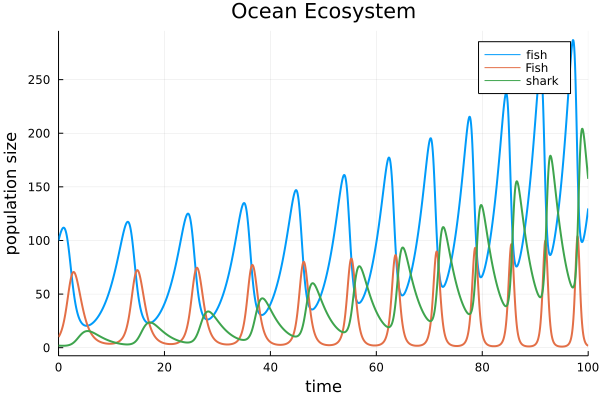

In [10]:
# Compose
ocean_system = oapply(ocean_pattern, [fish, FISH, sharks])

# Solve and plot
u0 = [100.0, 10, 2.0]
tspan = (0.0, 100.0)

prob = ODEProblem(ocean_system, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, ocean_system,
    lw=2, title = "Ocean Ecosystem",
    xlabel = "time", ylabel = "population size"
)

## Total ecosystem
### Another layer of composition

We will introduce a final predation interaction -- hawks eat little fish --  which will combine the land and ocean ecosystems.
The composition will be as resource shareres so the first thing we will do is use the dynamics of the machine `ocean_system` to define the dynamics of a resource sharer. We will also define a resource sharer that models hawk/little fish predation.

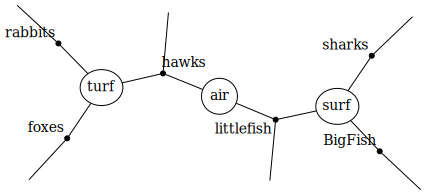

In [11]:
# Define the additional primitive systems
ocean_system_rs = ContinuousResourceSharer{Float64}(3, (u,p,t) -> eval_dynamics(ocean_system, u, [], p))

dothf(u,p,t) = [p.γfishh*u[1]*u[2], -p.βfishh*u[1]*u[2]]
fishhawk_predation = ContinuousResourceSharer{Float64}(2, dothf)

# Define the composition pattern
eco_pattern = @relation (rabbits, foxes, hawks, littlefish, BigFish, sharks)  begin
    turf(rabbits,foxes,hawks)
    air(hawks, littlefish)
    surf(littlefish, BigFish, sharks)
end

# Visualize the composition pattern
to_graphviz(eco_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))

In [12]:
# Compose

ecosystem = oapply(eco_pattern, Dict(
    :turf => land_system,
    :air => fishhawk_predation,
    :surf => ocean_system_rs)
)

We can now plot the evolution of the total ecosystem.

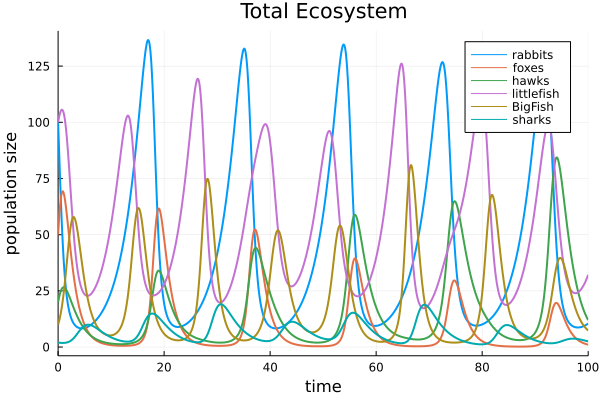

In [13]:
# Solve and plot
u0 = [100.0, 50.0, 20.0, 100, 10, 2.0]
tspan = (0.0, 100.0)

prob = ODEProblem(ecosystem, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, ecosystem,
    lw=2, title = "Total Ecosystem",
    xlabel = "time", ylabel = "population size"
)

Let's zoom in on a narrower time-window.

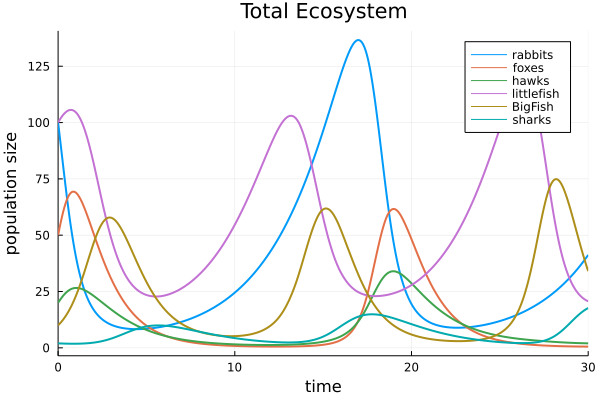

In [14]:
tspan = (0.0, 30.0)

prob = ODEProblem(ecosystem, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, ecosystem,
    lw=2, title = "Total Ecosystem",
    xlabel = "time", ylabel = "population size"
)

As a sanity check we can define the rates for the hawk/little fish predation to be 0. This decouples the land and ocean ecosystems. As expected, the plot shows the original evolution of the land ecosystem overlayed with the original evolution of the ocean ecosystem. This shows that they two ecosystems now evolve independently.

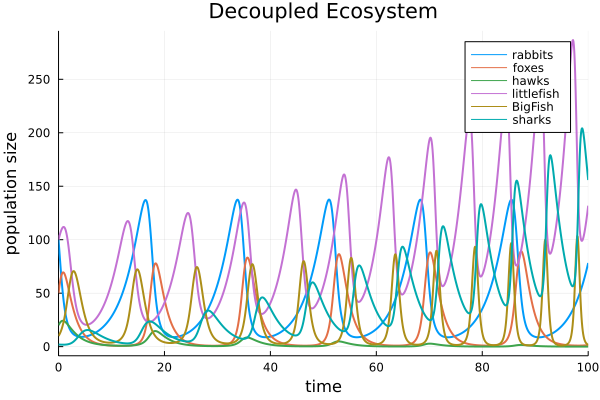

In [15]:
tspan = (0.0, 100.0)
params.βfishh = 0; params.γfishh = 0

prob = ODEProblem(ecosystem, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, ecosystem,
    lw=2, title = "Decoupled Ecosystem",
    xlabel = "time", ylabel = "population size"
)